In [35]:
import json
import glob
import os
import pickle

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
from enterprise import constants as const

from pptadr3 import dr3models
from snr_tools import cache_GGTlst, get_snr, snr_skymap
data_dir = './data'

## load data

Here we take the PPTA DR3 and its noise model as an example (base on https://github.com/danielreardon/PPTA-DR3.git), but you can replace it with any PTA pulsars and their corresponding noise models.

In [ ]:
with open(data_dir+'/30psrs.pkl', 'rb') as f:
    psrs = pickle.load(f)

with open(data_dir + '/noisedict.json', 'r') as f:
    noisedict = json.load(f)

if os.path.exists(data_dir+'/GGTlst.pkl'):
    with open(data_dir+'/GGTlst.pkl', 'rb') as f:
        GGTlst = pickle.load(f)
else:
    models = dr3models(psrs, marg_tm=False, crn='pl_nocorr_freegam', model="signal_models")
    GGTlst = cache_GGTlst(psrs, models=models, noisedict=noisedict, save=True, output=data_dir+'/GGTlst.pkl')

## CW upperlimit

In [ ]:
n_inject = 1000 # number of injected signals

target_snr= 5 # set target snr is 5

### **function "get_snr"**

**The possible values for parameter "signal_name" are:**
- "cw": continue gravitional
- "mem": memory
- "fdm": Ultralight dark matter
- "ecc": 

In [ ]:
result_60f = {}
freqs = np.logspace(-9, -6.6, 60)
for i, f in tqdm(enumerate(freqs), total=60):
    result_60f[i] = get_snr(n_inject, psrs, GGTlst, signal_name='cw', mean_snr=False, log10_fgw=np.log10(f))

In [ ]:
snrs_f = []
for i in range(60):
    snr_f = 0
    snr_f_dict = result_60f[i]
    snr_f_dict_k = np.array(list(snr_f_dict.values()))
    snr_f = np.sum(snr_f_dict_k)
    snrs_f.append((snr_f / n_inject / len(psrs))**0.5)

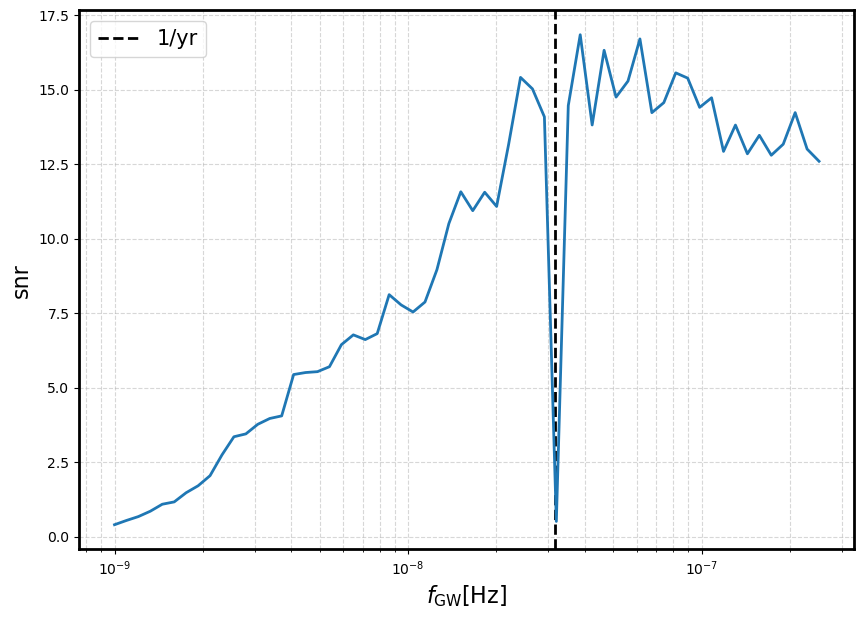

In [76]:
plt.figure(figsize=(10,7))

plt.gca().axvline(1/365.25/86400, ls='--', lw=2, color='xkcd:black', label='1/yr')
plt.plot(freqs, snrs_f, lw=2)

plt.legend(loc="upper left", fontsize=15, labelspacing=0.6)
plt.grid(which='both', linestyle='--', alpha=0.5)
ax = plt.gca()
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

plt.xlabel(r"$f_{\rm GW}$[Hz]", size=16)

plt.ylabel(r"snr", size=16)
plt.xscale("log")

In [79]:
factor = target_snr / np.array(snrs_f)

distlst = 100 / factor

In [80]:
def h0(lgmc, F, dl):
    nF = 10 ** (-9)

    F = F * nF

    return 2 * (const.G * 10 ** lgmc * const.Msun) ** (5/3) * (np.pi * F) ** (2/3) / (dl * const.Mpc) / const.c ** 4

In [81]:
hlst_ul = np.array([h0(9, freq*1e9, dl) for freq, dl in zip(freqs, distlst)])

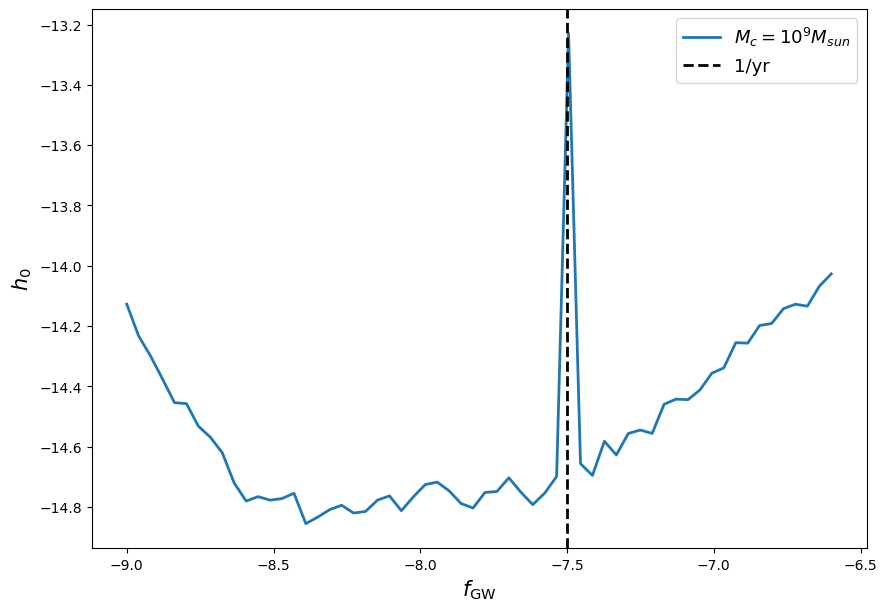

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(np.log10(freqs), np.log10(hlst_ul), lw=2, label=r"$M_c = 10^{9} M_{sun}$")

plt.gca().axvline(np.log10(1/365.25/86400), ls='--', lw=2, color='xkcd:black', label='1/yr')

plt.xlabel(r"$f_{\rm GW}$", size=15)

plt.ylabel(r"$h_0$", size=15)
plt.legend(prop={'size': 13})

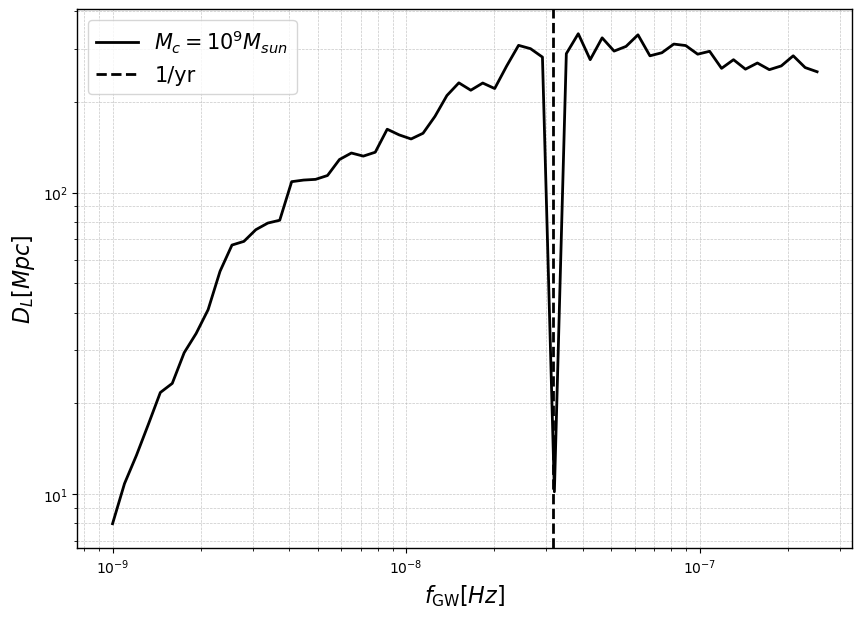

In [ ]:
plt.figure(figsize=(10, 7))

# plt.plot(freqs, distlst8, lw=2, label=r"$M_c = 10^{8} M_{sun}$", color='xkcd:blue')
plt.plot(freqs, distlst, lw=2, label=r"$M_c = 10^{9} M_{sun}$", color='xkcd:black')
# plt.plot(freqs, distlst10, lw=2, label=r"$M_c = 10^{10} M_{sun}$", color='xkcd:red')
plt.gca().axvline(1/365.25/86400, ls='--', lw=2, color='xkcd:black', label='1/yr')

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r"$f_{\rm GW}[Hz]$", size=16, fontweight='bold')
plt.ylabel(r"$D_L[Mpc]$", size=16, fontweight='bold')
plt.legend(prop={'size': 15})

plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

ax = plt.gca()
ax.spines['top'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

plt.show()


## CW skymap

In [ ]:
snr_sky = snr_skymap(psrs, GGTlst, signal_name='cw', log10_fgw=np.log10(22e-9))

In [ ]:
factor= target_snr / snr_sky

distlst_22nhz = 100 / factor

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
dat = distlst_22nhz
mv = hp.mollview(dat, rot = 180, title = r"$DL[Mpc](f_{GW}=27 nHz; M_c=10^9; S/N=5)$", hold = True, min=int(min(dat)), max=int(max(dat)) + 1)

for i in range(2,24,2):
    text = hp.projtext( i*180/12+3, 4,  str(i)+'h', lonlat=True, coord='G', fontsize = 'large', fontweight = 100, zorder = 1, color = 'w')

for i, psr in enumerate(psrs):
    # if psr.name == "J0437-4715":
    hp.visufunc.projscatter(psr.theta, psr.phi, marker = '*', s = 80, edgecolor = 'red', color = "red")
hp.graticule(15, 30)

## explore data